# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В процессе выполнения проекта мы посмотрим несколько моделей, попробуем подобрать лучшие гиперпараметры, а также посчитаем время выполнения обучения и предсказания. В качестве метрики качества используем RMSE (корень от среднеквадратичной ошибки). Но для начала мы посмотрим имеющиеся данные, оценим их качество (проверим на наличие ошибок) и проведем предобработку.

## Подготовка данных

### Загрузка и предварительная оценка качества данных

В самом начале импортируем все необходимые библиотеки

In [1]:
! pip install catboost


In [2]:
! pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor



from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV


Загрузим файл с данными и посмотрим на первые 5 строк.

In [4]:
auto = pd.read_csv('/datasets/autos.csv') #открываем файл

In [5]:
display(auto.head()) # посмотрим первые 5 строк

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В соответствии с документацией в таблице хранятся следующие данные:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)

In [6]:
auto.info() # просмотр информации о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В таблице 16 столбцов. У 7 тип данных int64, а у 9-ти тип object. Сразу видно, что в данных есть пропуски. В столбцах с датами тип данных object, который лучше перевести в тип datetime. Названия столбцов обновим, чтобы все названия были написаны в нижнем регистре.

В столбцах с типом кузова, типом коробки передач, моделью автомобиля, типом топлива и маркой автомобиля необходимо посмотреть список уникальных значений, чтобы убедиться, что там нет дублей, связанных с неправильным написанием. А также посмотрим столбцы с мощностью автомобиля и годом регистрации.

In [7]:
def unigue_value(columns):
    return columns.sort_values().unique()

In [8]:
print('Тип топлива:', unigue_value(auto['FuelType']))
print()
print('тип автомобильного кузова:', unigue_value(auto['VehicleType']))
print()
print('Модель:', unigue_value(auto['Model']))
print()
print('Тип коробки передач:', unigue_value(auto['Gearbox']))
print()
print('Марка:', unigue_value(auto['Brand']))
print()
print('Год регистрации автомобиля:', unigue_value(auto['RegistrationYear']))
print()
print('Мощность:', unigue_value(auto['Power']))

Тип топлива: ['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' nan]

тип автомобильного кузова: ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

Модель: ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' '

В столбце с типом топлива есть дубли: "gasoline" и "petrol". Это все разное написание бензина. Часть данных пропущена, и определить более точно, какой вид топлива должен быть в ячейках с пропущенными значеними без дополнительной информации не представляется возможным. Заменим пропуски на "unknown". Аналогично поступим с пропусками в столбце с типом кузова и видом коробки передач, потому что одна и та же модель может иметь разные виды кузова и быть как на механике, так и с автоматической коробкой передач.

В столбце с маркой автомобиля все в порядке: пропусков нет, дублей нет. Хотя есть "sonstige_autos" (пер.нем. "другие автомобили"). С этим пунктом нужно подумать, что делать, предварительно оценив количество строк с этим значением.

In [9]:
auto['Brand'].value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

"Другие автомобили" в 3374 строках. Пока не будем ничего делать с этими данными и посмотрим, как будут вести себя модели.

В графе с годом регистрации автомобиля очень много неверных значений, часть из них мы заменим постаравшись выявить логику возникновения ошибки, а там где не сможем удалим строки.

В столбце с мощностью тоже много артефактов. Здесь мы постараемся просто отсечь выбросы.

Далее проверим есть ли полностью дублирующиемя строки.

In [10]:
auto.duplicated().sum() # подсчет дублирующихся строк

4

**Вывод**

В этой части работы мы загрузили данные и обнаружили следующие проблемы:
- есть четыре полностью дублирующиеся строки. Мы их удалим.
- в данных пропущены значения некоторых признаков. Часть из них мы заменим, а часть удалим.
- заменим тип данных в столбцах с датами
- масштабируем признаки, потому что нам нужно будет строить ряд моделей чувствительных к масштабу.
- для удобства работы обновим названия столбцов
- категориальные признаки переведем в числовое выражение
- отсечем выбросы в данных

### Предобработка данных

В этом разделе последовательно исправим ошибки в данных и подготовим данные для построения модели. И начнем мы замены названия столбцов.

In [11]:
auto.columns # вывод списка названий столбцов

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [12]:
auto = auto.rename(columns = {'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year'  ,'Gearbox': 'gearbox',
       'Power': 'power', 'Model': 'model', 'Kilometer': 'kilometer', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand',
       'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code',
       'LastSeen': 'last_seen'}) # замена названий столбцов

In [13]:
auto.columns # вывод списка названий столбцов

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Изменим тип данных в столбцах с датами.

In [14]:
auto['date_crawled'] = pd.to_datetime(auto['date_crawled'], format='%Y-%m-%dT%H:%M:%S') 
auto['date_created'] = pd.to_datetime(auto['date_created'], format='%Y-%m-%dT%H:%M:%S') 

In [15]:
display(auto.head(2)) # просмотр 2 строк

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50


In [16]:
auto.dtypes #просмотр информации о типе данных

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
not_repaired                  object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen                     object
dtype: object

Тип данных успешно заненен.

Далее удалим полностью дублирущиеся строки.

In [17]:
auto = auto.drop_duplicates() #удаление дубликатов строк

Посмотрим количество пропущенных значений.

In [18]:
auto.isna().sum() # расчет количества пропущенных значений по столбцам

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Пропущены данные о типе коробки передач, модели автомобиля, типе автомобильного кузова, виде топлива и была ли машина в ремонте. 

Восстановить данные о марке автомобиля невозможно, но это один из ключевых признаков, помимо модели определяющих стоимость автомобиля. Учитывая, что выборка достаточно большая, а процент строк с пропущенными названиями моделей не велик (5,5%), такие данные мы удалим.

In [19]:
auto = auto.dropna(subset = ['model']) # удаление строк, где в графе модель пропущены значения

После удаления строк с неизвестной моделью, посмотрим сколько еще пропущенных значений у нас остатось по другим столбцам.

In [20]:
auto.isna().sum()

date_crawled              0
price                     0
vehicle_type          30662
registration_year         0
gearbox               15702
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             25732
brand                     0
not_repaired          62100
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

От части незаполненных данных мы избавились. В столбце с данными о ремонте, пропуски можно заменить на "unknown". Более сложная задача, что делать с пропусками в виде топлива, коробке передач и типе кузова. У одной модели может быть как механика, так и автоматическая коробка передач. Аналогично с типом кузова и топливом. Если бы у нас были фотографии автомобилей, то тогда можно было определить тип кузова, но руками это делать было бы долго, возможно потребовалась бы нейронная сеть, которая натренирована на изображения. Технический специалист возможно подсказал бы нам на каких моделях может быть только какой-то вид топлива, тип кузова или коробка передач. Но к сожалению, у нас подобных вспомогательных возможностей нет, поэтому данные о типе кузова и коробки передач заменим на "unknown".

In [21]:
auto['gearbox'] = auto['gearbox'].fillna("unknown")
auto['vehicle_type'] = auto['vehicle_type'].fillna("unknown")
auto['not_repaired'] = auto['not_repaired'].fillna("unknown")

In [22]:
display(auto.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07


В графе с типом топлива тоже есть пропуски, попробуем заменить их на наиболее часто встречающийся вид топлива для конкретной модели. Но для начала заменим дубликаты в видах топлива. В списке встречается два разных написания бензина: gasoline и petrol.

In [23]:
auto = auto.replace({'fuel_type':{'gasoline': 'petrol'}})

In [24]:
auto['fuel_type'] = auto['fuel_type'].fillna(auto.groupby('model')['fuel_type'].transform(lambda x: x.value_counts().index[0]))


Следующим пунктом обработаем ошибки в графе с датой регистрации автомобиля. Сразу определимся, что дата регистрации автомобиля не может быть больше 2016г, т.к. данные для исследования загружены из базы данных как раз в 2016г. Нижней границей возьмем 1950 г. Также в некоторых явно ошибочных значениях прослеживается некоторая логика. Например вероятнее всего, когда человек вносил 2010 г., он просто поставил 10, а система восприняла это как 1000. 

In [25]:
auto = auto.replace({'registration_year':{1000: 2010, 1200: 2012, 1300: 2013, 1400 :2014, 1500: 2015,
                                          1600 : 2016, 1800: 2018, 2066: 1966, 6000: 1960, 6500: 1965,
                                          7000: 1970, 7100: 1971, 7500: 1975, 7800: 1978, 8000: 1980,
                                          8200: 1982, 8500: 1985, 9000: 1990}})

In [26]:
print('Год регистрации автомобиля:', unigue_value(auto['registration_year'])) # посмотрим уникальные значения, оставшиеся после замены

Год регистрации автомобиля: [1001 1111 1234 1602 1910 1919 1923 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1941 1942 1943 1945 1947 1949 1950 1951 1952
 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966
 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980
 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2200 2290 2500
 2900 3000 3700 4000 4500 5000 5555 5900 5911 9999]


Далее отчечем выбросы за пределами интервала 1950-2016 гг. Одновременно у нас будут отсечены "непонятные" года, восстановить значения которых не представляется возможным.

In [27]:
auto = auto.loc[(auto['registration_year'] <=2016) & (auto['registration_year'] >=1950)] # отсечем выбросы 

In [28]:
print('Год регистрации автомобиля:', unigue_value(auto['registration_year']))

Год регистрации автомобиля: [1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


Годы привели в порядок. Далее разберемся с выбросами в данных о мощности автомобилей. Воспользовавшись дополнительными источниками (google) нашла, что LADA (ВАЗ) 1111 Ока – мощностью от 29 до 53 лошадиных сил. Для малого класса оптимальным комплектом лошадиных сил считается мощность от 80 до 200 л.с, при этом Матиз - 52 л.с. У Toyota LC 200 двигатели начинаются с 249 л.с. и заканчиваются представителем под 400 л.с. У Nissan Patrol - 405 лошадок. Самые крупный внедорожник Mercedes G-Класс предлагает двигатели на 245 и 422 лошадиные силы или Bentley с двигателем на 625 л.с. На данным момент одним из самых мощных автомобилей является электрический Lotus Evija с мощностью 2000 л.с. Вероятность, что на Lotus Evija попадет на обычный сайт по продаже автомобилей практически нулевая. Думаю, что нужно ограничиться интервалом 29-600 л.с.

In [29]:
auto = auto.loc[(auto['power'] <=600) & (auto['power'] >=29)]

Проверим есть ли в данных строки, где цена равна нулю. Вероятнее всего, это тоже ошибка.

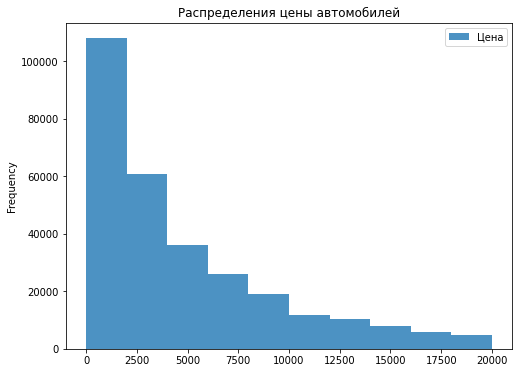

In [30]:
auto['price'].plot(kind = 'hist', y = 'Частота',
    label = 'Цена', alpha = 0.8,  figsize = (8,6), legend=True)



plt.title("Распределения цены автомобилей")
plt.show()

В данных есть нулевые значения. Конечно есть вероятность, что владелец просто хочет избавится от автомобиля, но в данном случае мы говорим о "продаже", а не "дарении", что предполагает наличие цены, пусть низкой, но цены. Поэтому будем считать нулевую цену ошибочной. Есть еще вариант, что подразумевалась "договорная цена", когда продавец и покупатель договариваются уже при личном общении. Еще несколько лет назад было принято указывать цену в договоре купли-продажи 10000 руб. (примерно 133 евро в ценах 2016г. (курс евро на 2016г примерно 75 руб за евро)), чтобы не было проблемм с налоговой. Если получится доказать, что продавец занизил цену без умысла, штраф составит 20% от неуплаченной суммы налога. И 40% — если есть доказательства об умышленном уклонении от уплаты налогов. Нижней границей установим 100 евро (сделаем поправку на колебание курса евро). Посмотрим, сколько у нас строк с ценой ниже 100 евро.

In [31]:
print(len(auto.loc[auto['price'] < 100]))

6608


Удалим эти строки.

In [32]:
auto = auto.loc[auto['price'] >= 100]

Не все данные нам нужны для построения моделей. На стоимость автомобиля влияют следующие факторы:

- vehicle_type — тип автомобильного кузова
- registration_year — год регистрации автомобиля
- gearbox — тип коробки передач
- power — мощность (л. с.)
- model — модель автомобиля
- kilometer — пробег (км)
- fuel_type — тип топлива
- brand — марка автомобиля
- not_repaired — была машина в ремонте или нет






Некоторые из этих признаков относятся к типу данных object и при этом являются категориальными признаками. Нам необходимо перевести их в числа. Для преобразования данных используем get_dummies.

In [33]:
auto = pd.get_dummies(auto, columns=['not_repaired', 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand'], drop_first=True)


In [34]:
display(auto.head())

,date_crawled,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code,last_seen,...,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
2,2016-03-14 12:52:21,9800,2004,163,125000,8,2016-03-14,0,90480,2016-04-05 12:47:46,...,0,0,0,0,0,0,0,0,0,0
3,2016-03-17 16:54:04,1500,2001,75,150000,6,2016-03-17,0,91074,2016-03-17 17:40:17,...,0,0,0,0,0,0,0,0,1,0
4,2016-03-31 17:25:20,3600,2008,69,90000,7,2016-03-31,0,60437,2016-04-06 10:17:21,...,0,0,1,0,0,0,0,0,0,0
5,2016-04-04 17:36:23,650,1995,102,150000,10,2016-04-04,0,33775,2016-04-06 19:17:07,...,0,0,0,0,0,0,0,0,0,0
6,2016-04-01 20:48:51,2200,2004,109,150000,8,2016-04-01,0,67112,2016-04-05 18:18:39,...,0,0,0,0,0,0,0,0,0,0


Данные преобразованы. Теперь разделим нашу выборку на признаки и целевой признак. При этом в признаках оставим, только те, которые действительно влияют на стоимость автомобиля.

In [35]:
features = auto.drop(['price', 'date_crawled', 'registration_month',
                      'number_of_pictures', 'postal_code', 'last_seen', 'date_created'], axis=1) #удаление целевого признака и ненужных признаков 
target = auto['price'] #целевой признак 

Для начала нам необходимо разделить данные на три части: на обучающую, валидационную и тестовую выборки. Обучающая выборка будет самой большой и вместит 60% данных. С помощью нее мы будем обучать модель. Вторая выборка валидационная (20% от объема данных), нужна нам для проверки качества работы алгоритма во время обучения модели. И последняя третья выборка - тестовая. Ее размер 20% от общего объема данных. На ней мы будем проверять качество обученной модели.

Для начала извлечем из общего набора 40% данных, которые потом поделим попалам и одна часть будет у нас валидационной выборкой, а вторая тестовой.

In [36]:
features_train, features_valid_test, target_train, \
 target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)

In [37]:
features_valid, features_test, target_valid, \
 target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

Два признака у нас имеют разный диапазон разброса значений (год регистрации и километраж). Поскольку многие из моделей, которые мы будем строить чувствительны к масштабу, то проведем масштабирование признаков с помощью StandardScaler.

In [38]:
pd.options.mode.chained_assignment = None

numeric = ['registration_year', 'kilometer', 'power']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


**Вывод**

В этой части проекта мы провели предобработку данных. В результате мы получили:
- даты теперь имеют тип Datetime
- названия столбцов написаны в нижнем регистре
- полностью дублирующиеся строки удалены
- строки, где пропущено название модели удалены, поскольку восстановить информацию не представляется возможным, а это один из ключевых признаков определяющих стоимость автомобиля
- пропуски в столбцах с типом кузова и коробкой передач заменили на "unknown", т.к у одной и той же модели могут быть разные коробки передач и вид кузова. Информацию о том, был ли ремонт или нет, восстановить не возможно, поэтому тоже заменили на "unknown"
- в столбце с пропущенным видом топлива заменили пропуски на наиболее часто встречающееся значение для данной модели. Но перед этим исправили дубликаты в названиях топлива.
- обработали столбец с годом регистрации автомобиля. Где прослеживается логика, там заменили значения. Установили допустимый интервал регистрации автомобилей с 1950 по 2016 г. Все остальные значения отсекли как выбросы.
- проанализировали мощность автомобилей. На основе данных полученных из дополнительных источников, ограничили интервал диапазоном 29-600 л.с. Все остальные значения удалили.
- в последнюю очередь обработали строки с ценой, убрав из выборки строки с "сомнительной" ценой.

## Обучение моделей

В качестве метрики качества будем использовать RMSE . Напишем функцию для ее расчета.

In [39]:
def rmse(target, predicted):
    
    return mean_squared_error(target, predicted)**0.5

rmse_score = make_scorer(rmse, greater_is_better = False)

Мы построим несколько моделей, оценим их качество и измерим время работы. Время предлагаю измерять следующим образом: отдельно посчитать подбор гиперпараметров с помощью GridSearchCV или RandomizedSearchCV (где они необходимы) плюс обучение модели и отдельно скорость предсказания. На лучшей модели посмотрим метрику качества и скорость предсказания на тестовой выборке.

Для того, чтобы измененное нами время отображалось в виде час-минуты-секунды-миллисекунды напишем функцию:

In [40]:
def convert_to_preferred_format(ms): # функция преобразовывает время в миллисекунды, а затем считает количество целых часов, минут, секунд и миллисекунд 
    ms = ms % (24 * 3600 * 1000)
    hour = ms // 3600000
    ms %= 3600000
    min = ms // 60000
    ms %= 60000
    sec = ms // 1000
    ms %= 1000
   
    
    return "%02d:%02d:%02d:%03d" % (hour, min, sec, ms)


### Дерево решений

В первой моделе мы посчитаем время двумя способами: с помощью модуля time и функции time.time(), а второй (контрольный способ, чтобы проверить, что наша функция convert_to_preferred_format работает верно) - это %%time. В последующих моделях %%time мы использовать уже не будем. 

In [41]:
%%time
start_fit_dtr = time.time()
clf_dtr = DecisionTreeRegressor(random_state=12345)
parametrs = {'max_depth': range (1,10, 1),
            }
grid_dtr = GridSearchCV(clf_dtr, parametrs, cv = None)
grid_dtr.fit(features_train, target_train)
print(grid_dtr.best_params_)
print()
end_time_fit_dtr = time.time() - start_fit_dtr
end_time_fit_dtr = convert_to_preferred_format(end_time_fit_dtr * 1000)
print("Время в формате h-m-s-ms :", end_time_fit_dtr)
print()

{'max_depth': 9}

Время в формате h-m-s-ms : 00:01:05:722

CPU times: user 57.2 s, sys: 8.47 s, total: 1min 5s
Wall time: 1min 5s


Лучший результат при 9 деревьях. Время обучения и подбора гиперпараметров невысокое. Тот же показатель и при использовании time.time(), только добавились миллисекунды.

In [42]:
%%time
start_pred_dtr = time.time()
predicted_valid = grid_dtr.predict(features_valid)
print('Дерево решений (с подбором гиперпараметров):')
rmse_dtr = rmse(target_valid, predicted_valid)
print('RMSE: {:.2f}'.format(rmse_dtr))
print()
end_time_pred_dtr = time.time() - start_pred_dtr
end_time_pred_dtr = convert_to_preferred_format(end_time_pred_dtr * 1000)
print("Время в формате h-m-s-ms :", end_time_pred_dtr)
print()

Дерево решений (с подбором гиперпараметров):
RMSE: 2005.08

Время в формате h-m-s-ms : 00:00:00:102

CPU times: user 37.1 ms, sys: 63.2 ms, total: 100 ms
Wall time: 103 ms


Предсказание очень быстрое. Показатель RMSE: 2005.08

### Линейная регрессия

In [43]:
start_fit_lr = time.time()

model_lr = LinearRegression() 
model_lr.fit(features_train, target_train) 

end_time_fit_lr = time.time() - start_fit_lr
end_time_fit_lr = convert_to_preferred_format(end_time_fit_lr * 1000)

print("Время в формате h-m-s-ms :", end_time_fit_lr)
print()

Время в формате h-m-s-ms : 00:00:28:020



In [44]:
start_pred_lr = time.time()

predicted_valid = model_lr.predict(features_valid)
rmse_lr = rmse(target_valid, predicted_valid)
print('Линейная регрессия:')
print('RMSE: {:.2f}'.format(rmse_lr))
print()
end_time_pred_lr = time.time() - start_pred_lr
end_time_pred_lr = convert_to_preferred_format(end_time_pred_lr * 1000)
print("Время в формате h-m-s-ms :", end_time_pred_lr)
print()

Линейная регрессия:
RMSE: 2550.62

Время в формате h-m-s-ms : 00:00:00:188



Обучение также быстрое и предсказание тоже. Правда показатель RMSE достаточно высокий - 2550,62.

### Модель Лассо

Следующая на очереди модель Лассо.

In [45]:
import warnings
warnings.simplefilter("ignore")

start_fit_lasso = time.time()

model_lasso = Lasso(random_state=12345) # модель Лассо 
model_lasso.fit(features_train, target_train) 

end_time_fit_lasso = time.time() - start_fit_lasso
end_time_fit_lasso = convert_to_preferred_format(end_time_fit_lasso * 1000)

print("Время в формате h-m-s-ms :", end_time_fit_lasso)
print()



Время в формате h-m-s-ms : 00:03:47:588



In [46]:
start_pred_lasso = time.time()

predicted_valid = model_lasso.predict(features_valid)
rmse_lasso = rmse(target_valid, predicted_valid)
print('Модель Лассо:')
print('RMSE: {:.2f}'.format(rmse_lasso))

print()
end_time_pred_lasso = time.time() - start_pred_lasso
end_time_pred_lasso = convert_to_preferred_format(end_time_pred_lasso * 1000)
print("Время в формате h-m-s-ms :", end_time_pred_lasso)
print()

Модель Лассо:
RMSE: 2588.03

Время в формате h-m-s-ms : 00:00:00:241



Модель Лассо обучалась в пределах 10 минут (за несколько прогонов получила несколько разных показаний времени, но все они были в пределаж 2-10 минут). Ппредсказание все еще измеряется в миллисекундах. При этом RMSE хуже всех- 2588.03. Возможно подбор гиперпараметров, мог бы улучшить результат, но при этом увеличится время обучения.

### Случайный лес

Случайный лес с подбором гиперпараметров обычно дает лучший результат, чем предыдущие три модели, но основная его проблема в том, что обучается он долго. На небольших наборах данных для подбора гиперпараметров я обычно использую GridSearchCV, но в данном случае попробуем применить RandomizedSearchCV. Вероятнее всего с помощью GridSearchCV мы могли бы найти более оптимальные гиперпараметры, но в целях экономии времени применим RandomizedSearchCV.

In [47]:
start_fit_rfg  = time.time()

clf_rfg = RandomForestRegressor(random_state=12345)
parametrs = {'n_estimators': range (30, 101),
              'max_depth': range (1,21),
            }
grid_rfg  = RandomizedSearchCV(clf_rfg , parametrs, cv = None, n_iter = 10, scoring = rmse_score)
grid_rfg.fit(features_train, target_train)
print(grid_dtr.best_params_)
print()
end_time_fit_rfg  = time.time() - start_fit_rfg
end_time_fit_rfg = convert_to_preferred_format(end_time_fit_rfg  * 1000)

print("Время в формате h-m-s-ms :", end_time_fit_rfg)
print()

{'max_depth': 9}

Время в формате h-m-s-ms : 01:13:02:160



In [48]:
start_pred_rfg  = time.time()

predicted_valid = grid_rfg.predict(features_valid)
rmse_rfg  = rmse(target_valid, predicted_valid)
print('Случайный лес:')
print('RMSE: {:.2f}'.format(rmse_rfg))

print()
end_time_pred_rfg  = time.time() - start_pred_rfg 
end_time_pred_rfg = convert_to_preferred_format(end_time_pred_rfg  * 1000)
print("Время в формате h-m-s-ms :", end_time_pred_rfg)
print()

Случайный лес:
RMSE: 1586.50

Время в формате h-m-s-ms : 00:00:00:749



Обучение заняло около часа. При этом мы получили достаточно хороший показатель RMSE: 1586,50

### CatBoost

Попробуем постоить предсказание с помощью CatBoostRegressor. Гиперпараметры подберем с помощью GridSearchCV.

In [49]:
start_fit_cat  = time.time()

model_cat = CatBoostRegressor(random_state=12345, loss_function='RMSE')
parametrs = {'depth': range (5, 20, 5),
             'iterations': range (50, 201, 20)
            }
grid_cat = GridSearchCV(model_cat, parametrs, cv = None)
grid_cat.fit(features_train, target_train, verbose=10)
print(grid_cat.best_params_)
print()
end_time_fit_cat  = time.time() - start_fit_cat
end_time_fit_cat = convert_to_preferred_format(end_time_fit_cat  * 1000)

print("Время в формате h-m-s-ms :", end_time_fit_cat)
print()


Learning rate set to 0.5
0:	learn: 3346.1088284	total: 64.8ms	remaining: 3.17s
10:	learn: 1963.2954317	total: 209ms	remaining: 742ms
20:	learn: 1835.3869050	total: 347ms	remaining: 479ms
30:	learn: 1773.0120561	total: 480ms	remaining: 294ms
40:	learn: 1734.1503035	total: 627ms	remaining: 138ms
49:	learn: 1704.3226944	total: 750ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3343.2477256	total: 14.7ms	remaining: 718ms
10:	learn: 1965.7842638	total: 153ms	remaining: 542ms
20:	learn: 1823.3641396	total: 291ms	remaining: 401ms
30:	learn: 1769.5422087	total: 435ms	remaining: 267ms
40:	learn: 1730.1585511	total: 567ms	remaining: 125ms
49:	learn: 1701.2463467	total: 696ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3321.5435291	total: 15.2ms	remaining: 744ms
10:	learn: 1955.7363351	total: 162ms	remaining: 575ms
20:	learn: 1845.5078494	total: 314ms	remaining: 434ms
30:	learn: 1778.5753856	total: 454ms	remaining: 278ms
40:	learn: 1742.2379355	total: 581ms	remaining: 128ms
49:	learn: 

In [50]:
start_pred_cat  = time.time()

predicted_valid = grid_cat.predict(features_valid)
rmse_cat  = rmse(target_valid, predicted_valid)
print('CatBoost:')
print('RMSE: {:.2f}'.format(rmse_cat))

print()
end_time_pred_cat  = time.time() - start_pred_cat 
end_time_pred_cat = convert_to_preferred_format(end_time_pred_cat  * 1000)
print("Время в формате h-m-s-ms :", end_time_pred_cat)
print()

CatBoost:
RMSE: 1506.01

Время в формате h-m-s-ms : 00:00:00:177



Обучение шло в районе часа. Предсказание по прежнему не превышает секунды. И пока мы получили лучший показатель RMSE- 1506.01

### LGBM

Последней обучим модель LGBMRegressor. Гиперпараметры опять будем подбирать с помощью GridSearchCV. Как и многие бустинги эта модель хорошо работает с большим количеством деревьев.

In [51]:
start_fit_lgbm  = time.time()

est_list = []
depth_list = []
for est in range(600, 1001, 200):
    est_list.append(est) 
for depth in range(5, 16, 3):
        depth_list.append(depth)
     
    
params = {'max_depth': depth_list, 
          'n_estimators': est_list 
              }
model_lgbm = LGBMRegressor(random_state=12345)
            
grid_lgbm = GridSearchCV(model_lgbm, params, cv = None)
grid_lgbm.fit(features_train, target_train)
#grid_lgbm.fit(features_train, target_train, verbose=10)
print(grid_lgbm.best_params_)
print()
end_time_fit_lgbm  = time.time() - start_fit_lgbm
end_time_fit_lgbm = convert_to_preferred_format(end_time_fit_lgbm  * 1000)

print("Время в формате h-m-s-ms :", end_time_fit_lgbm)
print()

{'max_depth': 14, 'n_estimators': 1000}

Время в формате h-m-s-ms : 01:51:35:901



In [52]:
start_pred_lgbm  = time.time()

predicted_valid = grid_lgbm.predict(features_valid)
rmse_lgbm  = rmse(target_valid, predicted_valid)
print('LGBMRegressor:')
print('RMSE: {:.2f}'.format(rmse_lgbm))

print()
end_time_pred_lgbm  = time.time() - start_pred_lgbm 
end_time_pred_lgbm = convert_to_preferred_format(end_time_pred_lgbm  * 1000)
print("Время в формате h-m-s-ms :", end_time_pred_lgbm)
print()

LGBMRegressor:
RMSE: 1513.86

Время в формате h-m-s-ms : 00:00:06:543



Обучение заняло в районе 2-х часов. Предсказание 7 секунд, дольше, чем у многих других моделей. RMSE -1513,86

## Анализ моделей

В предыдущем разделе мы обучили несколько моделей и сделали по ним предсказания. Далее сведем все данные в одну таблицу и посмотрим результат:

In [53]:
score_data = {'RSME': [rmse_dtr , rmse_lr, rmse_lasso, rmse_rfg, rmse_cat, rmse_lgbm],
             'Время обучения': [end_time_fit_dtr, end_time_fit_lr, end_time_fit_lasso, end_time_fit_rfg, end_time_fit_cat, end_time_fit_lgbm],
              'Время предсказания': [end_time_pred_dtr, end_time_pred_lr, end_time_pred_lasso, end_time_pred_rfg, end_time_pred_cat, end_time_pred_lgbm]
             }
score_df = pd.DataFrame(score_data, index = ['Дерево решений', 'Линейная регрессия', 'Модель Лассо', 'Случайный лес', 'CatBoost', 'LGBM'])

print('Результаты RMSE  моделей и время их работы')
display(score_df)

Результаты RMSE  моделей и время их работы


,RSME,Время обучения,Время предсказания
Дерево решений,2005.077817,00:01:05:722,00:00:00:102
Линейная регрессия,2550.616011,00:00:28:020,00:00:00:188
Модель Лассо,2588.025861,00:03:47:588,00:00:00:241
Случайный лес,1586.503962,01:13:02:160,00:00:00:749
CatBoost,1506.006257,00:54:23:368,00:00:00:177
LGBM,1513.859796,01:51:35:901,00:00:06:543


Итак самой быстрой оказалась линейная регрессия, но показатель RMSE достаточно высокий. Неплохое сочетание качества и скорости дает дерево решений. Но помня о том, что эта модель очень легко переобучается, не стоит рассматривать ее как перспективную для нашего анализа. Случайный лес с подбором гиперпараметров, показал очень хороший результат RMSE, но при этом сам подбор гиперпараметров и обучение заняли очень много времени. Лидером по показателю качества предсказания стала модель CatBoost. При этом скорость предсказания у нее невысокая (около 200 миллисекунд). Однако подбор гиперпараметров и обучение шли достаточно долго (в районе часа). С небольшим отставанием в качестве за ней следует модель LGBM (RMSE = 1513,9). Не смотря на то, что интервал для подбора гиперпараметров задан достаточно небольшой большой, эта модель обучилась медленнее остальных, чем CatBoost, но время отклика предсказания больше, чем у всех остальных. 

Проанализировав полученные данные, предлагаю как основную использовать модель CatBoost. Проверим ее на тестовой выборке.

In [54]:
start_pred_cat_test  = time.time()

predicted_test = grid_cat.predict(features_test)
rmse_cat_test  = rmse(target_test, predicted_test)
print('CatBoost:')
print('RMSE: {:.2f}'.format(rmse_cat_test))

print()
end_time_pred_cat_test  = time.time() - start_pred_cat_test 
end_time_pred_cat_test = convert_to_preferred_format(end_time_pred_cat_test  * 1000)
print("Время в формате h-m-s-ms :", end_time_pred_cat_test)
print()

CatBoost:
RMSE: 1510.77

Время в формате h-m-s-ms : 00:00:00:127



Показатель качества достаточно хороший. Время предсказания не высокое (менее 160 миллисекунд). Показания немного хуже, чем на валидационной выборке, но не значительно.

## Общий вывод

Целью нашего проекта было на основании исторических данных обучить несколько моделей и найти ту, которая предсказывала бы стоимость автомобилей с минимальной ошибкой и при этом тратила бы на предсказание не большое время.

Мы посмотрели предоставленные для анализа данные и выявили несколько ошибок и неточностей:
- есть четыре полностью дублирующиеся строки.
- в данных пропущены значения некоторых признаков.
- неверный тип данных в столбцах с датами
- категориальные признаки имеют тип object
- в данных есть выбросы.

На втором этапе мы провели предобработку данных.
- в датах заменили тип на Datetime (данный столбцы не учавствуют в построении модели, но мы их обработали, потому что в какой-то момент, построение моделей может оказаться не конечной целью и чтобы не прободить предобработку заново, делаем это сразу)
- названия столбцов написаны в нижнем регистре (для удобства)
- полностью дублирующиеся строки удалили
- строки, где пропущено название модели удалены, поскольку восстановить информацию не представляется возможным, а это один из ключевых признаков определяющих стоимость автомобиля
- пропуски в столбцах с типом кузова и коробкой передач заменили на "unknown", т.к у одной и той же модели могут быть разные коробки передач и вид кузова. Информацию о том, был ли ремонт или нет, восстановить не возможно, поэтому тоже заменили на "unknown"
- в столбце с пропущенным видом топлива заменили пропуски на наиболее часто встречающееся значение для данной модели. Но перед - этим исправили дубликаты в названиях топлива. В списке встречались два разных написания бензина: gasoline и petrol.
- обработали столбец с годом регистрации автомобиля. Где прослеживается логика, там заменили значения. Сразу определились, что дата регистрации автомобиля не может быть больше 2016г, т.к. данные для исследования загружены из базы данных как раз в 2016г. Нижней границей взяли 1950 г. Также в некоторых явно ошибочных значениях прослеживалась некоторая логика. Например вероятнее всего, когда человек вносил 2010 г., он просто поставил 10, а система восприняла это как 1000.Установили допустимый интервал регистрации автомобилей с 1950 по 2016 г. Все остальные значения отсекли как выбросы.
- проанализировали мощность автомобилей. На основе данных полученных из дополнительных источников, ограничили интервал диапазоном 29-600 л.с. Все остальные значения удалили.
- в последнюю очередь обработали строки с ценой, убрав из выборки строки с "сомнительной" ценой. При этом придерживались следующей позиции, что еще несколько лет назад было принято указывать цену в договоре купли-продажи 10000 руб. (примерно 133 евро в ценах 2016г. (курс евро на 2016г примерно 75 руб за евро)), чтобы не было проблемм с налоговой. Нижней границей установили 100 евро (сделаем поправку на колебание курса евро). Верхнюю планку исправлять не стали, потому, что цена в 20000 евро, вполне могла быть на автомобили.

Далее мы обучили 6 моделей: Дерево решений, линейную регрессию, модель Лассо, Случайный лес, CatBoost, LGBM. В большинстве случаев, за исключением линейной регрессии и модели Лассо мы подбирали гиперпараметры с помощью GridSearchCV, а у Случайного леса использовали RandomizedSearchCV. В качестве метрики качества использовали корень из среднеквадратичной ошибки (RMSE). Отдельно посчитали время, затрачиваемое на обучение и отдельно на предсказание. Лидером по качеству оказалась модель CatBoost. Лидером по скорости обучения и предсказания - линейная регрессия.

Проанализировав полученные метрики, я пришла к выводу, что не смотря на большое время, затрачиваемое на обучение, модель  CatBoost лучше всех подходит для решения поставленной задачи. Результат, который показывает эта модель на тестовой выборке, нас вполне удовлетворяет - он совсем не значительно отличается от результата полученного на валидационной выборке.

In [55]:
score_data = {'RSME': [rmse_dtr , rmse_lr, rmse_lasso, rmse_rfg, rmse_lgbm, rmse_cat, rmse_cat_test],
             'Время обучения': [end_time_fit_dtr, end_time_fit_lr, end_time_fit_lasso, end_time_fit_rfg, end_time_fit_lgbm, end_time_fit_cat, '-'], 
              'Время предсказания': [end_time_pred_dtr, end_time_pred_lr, end_time_pred_lasso, end_time_pred_rfg, end_time_pred_lgbm, end_time_pred_cat, end_time_pred_cat_test ]
             }
score_df = pd.DataFrame(score_data, index = ['Дерево решений', 'Линейная регрессия', 'Модель Лассо', 'Случайный лес', 'LGBM', 'CatBoost', 'CatBoost тест'])

print('Результаты RMSE  моделей и время их работы')
display(score_df)

Результаты RMSE  моделей и время их работы


,RSME,Время обучения,Время предсказания
Дерево решений,2005.077817,00:01:05:722,00:00:00:102
Линейная регрессия,2550.616011,00:00:28:020,00:00:00:188
Модель Лассо,2588.025861,00:03:47:588,00:00:00:241
Случайный лес,1586.503962,01:13:02:160,00:00:00:749
LGBM,1513.859796,01:51:35:901,00:00:06:543
CatBoost,1506.006257,00:54:23:368,00:00:00:177
CatBoost тест,1510.766667,-,00:00:00:127
